In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [63]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [208]:
def edit_epoch(df, stage, iter_per_ep, num_ep):
    df['epoch'] += 1+(stage-1)*num_ep
    df['iteration'] = iter_per_ep*df['epoch']
    return df

def parse_fname(fp):
#     train_val_scores_g0_seed_262_dev_notime.csv
# train_val_scores_g0_seed_262_adev_notime_pre.g2g1.csv
# gradmean_g2_seed_262_adev_notime.json
# gradsnr_g1_seed_261_adev_notime_pre.g2.json
    parts = Path(fp).stem.split('_')
    if parts[0]=='train':
        _,_,_,current_gr, _,seed, curr, *other = parts
    elif parts[0][:4]=='grad':
        prefix, current_gr, _, seed, curr, *other = parts
    
    cond = other[0]
    previous_gr = ''
    if len(other)>1:
        previous_gr += other[1].replace('pre.', '')
    train_gr = previous_gr+current_gr
    
    tag_dict = {
        'Curriculum':curr,
        'Condition':cond,
        'Seed': seed,
        'Train Groups': train_gr,
        'data_id': '_'.join([curr, seed, cond])
    }
    return tag_dict
    
    
def proc_fp_train(fp, stage, num_ep, iter_per_ep):
    df = pd.read_csv(fp).iloc[:,1:]
    df = edit_epoch(df, stage, iter_per_ep, num_ep)
    tag_dict = parse_fname(fp)
    for tag in tag_dict.keys():
        df[tag] = tag_dict[tag]
    df = df.rename(columns={
    'epoch': 'Epoch',
    'iteration': 'Iteration',
    'train_loss': 'Train Loss',
    'val_loss': 'Validation Loss'
    })
    df['Train Loss Reduction'] = df['Train Loss'].diff(periods=-1)
    df['Validation Loss Reduction'] = df['Validation Loss'].diff(periods=-1)
    return df


def proc_dir_gradient(result_dir, stat='mean', pgr_name='pgr12'):
    # result_dir example: baby_vision_curriculum/trained_models/generative/v2/jun27/s2/gradients
    if stat!='mean':
        raise NotImplementedError
    stage_mean = {}
#     all_std = {}
#     all_snr = {}
    result_files = [Path(result_dir,item)
                    for item in os.listdir(result_dir)
                   if Path(result_dir,item).suffix=='.json']
    
    for fp in result_files:
        parts = Path(fp).stem.split('_')
        prefix, glast, _, seed, curr, *plast = parts
        tag_dict = parse_fname(fp)
        data_id = tag_dict['data_id']
        
        if prefix=='gradmean':
            with open(fp, "r") as json_file:
                json_data = json.load(json_file)
            gradmean_ts = np.asarray(json_data[pgr_name])
            stage_mean[data_id]=gradmean_ts
    return stage_mean#, all_std#, all_snr   

In [209]:
def proc_result_folder(root, num_ep, iter_per_ep):
    grad_dict = {}
    dftrain_list = []
    folders = sorted(list(os.listdir(root)))
    for stage in range(1,4):
        stage_str = 's'+str(stage)
        if stage_str in folders:
            result_dir = str(Path(root, stage_str))
            for item in os.listdir(result_dir):
                first_part = item.split('_')[0]
                fp = str(Path(result_dir,item))
                if first_part=='train':
#                     print(stage, fp)
                    dftrain_list.append(
                        proc_fp_train(fp, stage, num_ep, iter_per_ep))
                elif first_part=='model':
                    pass
                elif first_part=='gradients':
                    grad_dict[stage] = proc_dir_gradient(fp, stat='mean', pgr_name='pgr12')
    return dftrain_list, grad_dict

In [218]:
num_ep, iter_per_ep = 5, 2000
iter_per_stage = num_ep*iter_per_ep
result_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/jun26/'
dftrain_list, grad_dict = proc_result_folder(result_root, num_ep, iter_per_ep)
df_all = pd.concat(dftrain_list,ignore_index=True)
condition_mapdict={'default':'space matched',
                  'notime':'space & time matched'}
df_all['Condition'] = df_all['Condition'].map(condition_mapdict)

In [173]:
print(len(dftrain_list))
print(len(grad_dict))
print(len(grad_dict[1]))

12
3
4


In [219]:
result_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/jun27/'
num_ep, iter_per_ep = 5, 2000
dftrain_list2, grad_dict2 = proc_result_folder(result_root, num_ep, iter_per_ep)
df_all2 = pd.concat(dftrain_list2, ignore_index=True)
condition_mapdict={'default':'space matched',
                  'notime':'space & time matched'}
df_all2['Condition'] = df_all2['Condition'].map(condition_mapdict)

In [175]:
df_all = pd.concat((df_all, df_all2), ignore_index=True)

In [213]:
hue_order = ['dev',
            'adev']
style_order=['default','space matched','time matched','space & time matched']

In [228]:
def plot_multistage(cdata, x,y, ax, legend=True):
    sns.lineplot(data=cdata, x=x, y=y, hue='Curriculum', style='Condition', ax=ax,
                hue_order=hue_order, style_order=style_order, legend=legend)
    g = sns.scatterplot(data=cdata, x=x, y=y, hue='Curriculum', ax=ax, legend=False, s=10,
                   hue_order=hue_order)
#     if legend:
#         g.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1)
    
    maxval = cdata[y].max()
    # minval = cdata[y].min()
    # ax.set_ylim([-0.1,maxval*1.3])
    ax.axvline(x=1000, color='gray', linestyle=':')
    for stage in range(1,4):
        baseline = iter_per_stage*(stage-1)
        stage_end = iter_per_stage*stage
        ax.axvline(x=stage_end, color='gray', linestyle=':')
        
        if legend:
            ax.annotate('Stage '+str(stage), xy=(1000+baseline, maxval), xytext=(500+baseline, maxval),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    if legend:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # Shrink current axis's height by 10% on the bottom
#         box = ax.get_position()
#         ax.set_position([box.x0, box.y0 + box.height * 0.1,
#                          box.width, box.height * 0.9])

#         # Put a legend below current axis
#         ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#                   fancybox=True, shadow=True, ncol=5)

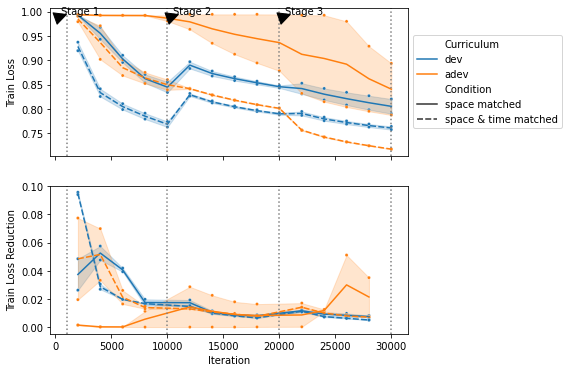

In [185]:
cdata = df_all
fig,ax = plt.subplots(2,1, figsize=(8,6), sharex=True)

x,y='Iteration','Train Loss'
plot_multistage(cdata, x,y, ax[0], legend=True)

x,y='Iteration','Train Loss Reduction'
plot_multistage(cdata, x,y, ax[1], legend=False)

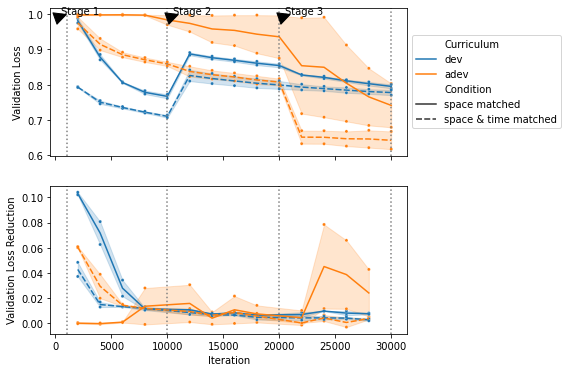

In [186]:
cdata = df_all
fig,ax = plt.subplots(2,1, figsize=(8,6), sharex=True)

x,y='Iteration','Validation Loss'
plot_multistage(cdata, x,y, ax[0], legend=True)

x,y='Iteration','Validation Loss Reduction'
plot_multistage(cdata, x,y, ax[1], legend=False)

# plt.tight_layout(rect=[0, 0, 0.8, 1])

In [220]:
result_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/jun21/'
num_ep, iter_per_ep = 5, 2000
dftrain_list3, grad_dict2 = proc_result_folder(result_root, num_ep, iter_per_ep)
df_all3 = pd.concat(dftrain_list3, ignore_index=True)
df_all3['Condition'] = df_all3['Condition'].map({'default':'time matched'})

In [190]:
# df_all = pd.concat((df_all, df_all3), ignore_index=True)

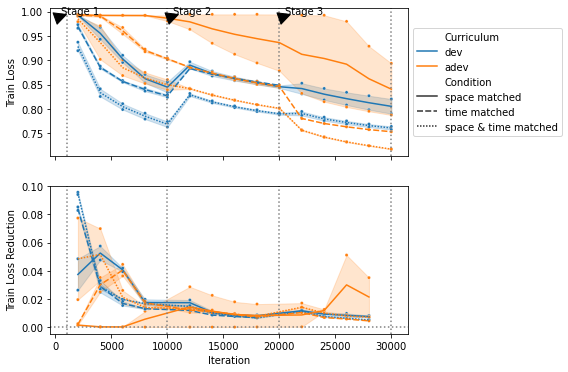

In [199]:
cdata = df_all
fig,ax = plt.subplots(2,1, figsize=(8,6), sharex=True)

x,y='Iteration','Train Loss'
plot_multistage(cdata, x,y, ax[0], legend=True)

x,y='Iteration','Train Loss Reduction'
plot_multistage(cdata, x,y, ax[1], legend=False)
# ax[0].axhline(y=1, color='gray', linestyle=':')
ax[1].axhline(y=0, color='gray', linestyle=':')

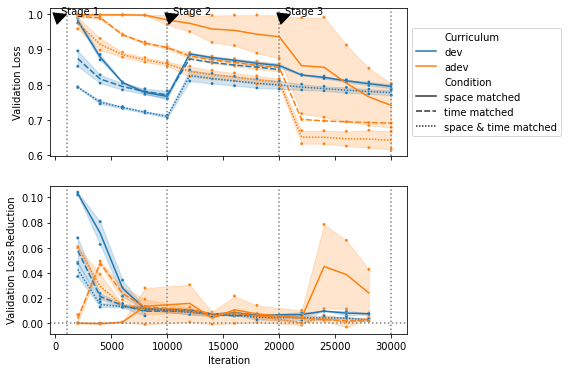

In [200]:
cdata = df_all
fig,ax = plt.subplots(2,1, figsize=(8,6), sharex=True)

x,y='Iteration','Validation Loss'
plot_multistage(cdata, x,y, ax[0], legend=True)

x,y='Iteration','Validation Loss Reduction'
plot_multistage(cdata, x,y, ax[1], legend=False)
# ax[0].axhline(y=1, color='gray', linestyle=':')
ax[1].axhline(y=0, color='gray', linestyle=':')

In [221]:
result_root = '/N/project/baby_vision_curriculum/trained_models/generative/v2/jun15/'
num_ep, iter_per_ep = 5, 2000
dftrain_list4, grad_dict2 = proc_result_folder(result_root, num_ep, iter_per_ep)
df_all4 = pd.concat(dftrain_list4, ignore_index=True)
df_all4 = df_all4[df_all4['Condition']=='default']
# df_all4['Condition'] = df_all4['Condition'].map({'default':' matched'})

In [222]:
df_all = pd.concat((df_all, df_all2, df_all3, df_all4), ignore_index=True)

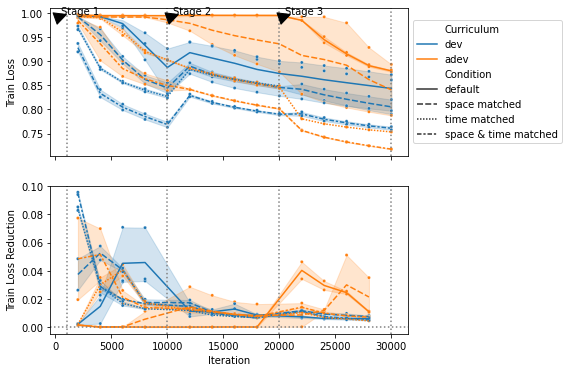

In [223]:
cdata = df_all
fig,ax = plt.subplots(2,1, figsize=(8,6), sharex=True)

x,y='Iteration','Train Loss'
plot_multistage(cdata, x,y, ax[0], legend=True)

x,y='Iteration','Train Loss Reduction'
plot_multistage(cdata, x,y, ax[1], legend=False)
# ax[0].axhline(y=1, color='gray', linestyle=':')
ax[1].axhline(y=0, color='gray', linestyle=':')

In [232]:
hue_order = ['dev',
            'adev']
style_order=['default','space & time matched']

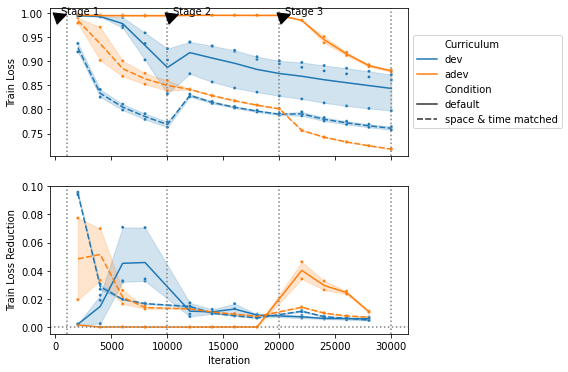

In [233]:
cdata = df_all[df_all['Condition'].isin(style_order)]
fig,ax = plt.subplots(2,1, figsize=(8,6), sharex=True)

x,y='Iteration','Train Loss'
plot_multistage(cdata, x,y, ax[0], legend=True)

x,y='Iteration','Train Loss Reduction'
plot_multistage(cdata, x,y, ax[1], legend=False)
# ax[0].axhline(y=1, color='gray', linestyle=':')
ax[1].axhline(y=0, color='gray', linestyle=':')